Python application for extracting data from passport images. It utilizes Optical Character Recognition (OCR) to read information from Machine Readable Zones (MRZ) and other parts of the passport.



In [43]:
!pip install pytesseract  
!sudo apt install tesseract-ocr
!pip install easyocr
!pip install PassportEye


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 69 not upgraded.


In [44]:
import os
import string as st
from dateutil import parser
import matplotlib.image as mpimg
import cv2
from passporteye import read_mrz
import json
import easyocr
import warnings
import tempfile
import re
from IPython.display import Image


warnings.filterwarnings('ignore')

In [45]:
def plot_gray(image):
    """Plot a grayscale image."""
    plt.figure(figsize=(16, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.show()

In [46]:
def plot_rgb(image):
    """Plot an RGB image."""
    plt.figure(figsize=(16, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [60]:
def extract_text(image):
    """Extract text from the image using Tesseract OCR."""
    return pytesseract.image_to_string(image)

def get_ocr_data(image):
    """Get OCR data from the image using Tesseract OCR."""
    return pytesseract.image_to_data(image, output_type=Output.DICT)

def draw_boxes(image, ocr_data):
    """Draw bounding boxes around detected text in the image and return coordinates."""
    n_boxes = len(ocr_data['level'])
    box_coordinates = []
    for i in range(n_boxes):
        (x, y, w, h) = (ocr_data['left'][i], ocr_data['top'][i], ocr_data['width'][i], ocr_data['height'][i])
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        box_coordinates.append((x, y, w, h))
    return image, box_coordinates

In [50]:
class PassportDataExtractor:
    def __init__(self, country_codes_file, gpu=True):
        """Initialize the PassportDataExtractor with EasyOCR reader and country codes."""
        self.reader = easyocr.Reader(lang_list=['en'], gpu=gpu)
        with open(country_codes_file) as f:
            self.country_codes = json.load(f)

    def parse_birth_date(self, date_string):
        """Parse and format the birth date from the given date string."""
        try:
            date = parser.parse(date_string, yearfirst=True).date()
            if date.year >= 2000:
                date = date.replace(year=date.year - 100)
            return date.strftime('%d/%m/%Y')
        except ValueError:
            return None

    def parse_date(self, date_string):
        """Parse and format the date from the given date string."""
        try:
            # Handle specific format 'DD MMM / MMM YY'
            if re.match(r'\d{2} \b(?:JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)\b / \b(?:JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)\b \d{2}', date_string):
                parts = date_string.split(' / ')
                day_month = parts[0].split()
                year = parts[1].split()[-1]
                year = '19' + year if int(year) > 50 else '20' + year
                return f"{day_month[0]}/{day_month[1]}/{year}"

            # Handle specific format 'MMM YY'
            if re.match(r'\b(?:JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)\b \d{2}', date_string):
                month_year = date_string.split()
                year = month_year[1]
                year = '19' + year if int(year) > 50 else '20' + year
                return f"01/{month_year[0]}/{year}"

            date = parser.parse(date_string, yearfirst=True).date()
            return date.strftime('%d/%m/%Y')
        except ValueError:
            return None

    def clean(self, string):
        """Clean and format the string."""
        return ''.join(char for char in string if char.isalnum()).upper()

    def get_country_name(self, country_code):
        """Get the country name from the given country code."""
        for country in self.country_codes:
            if 'alpha-3' in country and country['alpha-3'] == country_code:
                return country['name']
        return country_code

    def find_authority(self, ocr_text):
        """Find the issuing authority from the OCR text."""
        keywords = ['ISSUING AUTHORITY', 'ISSUED BY', 'AUTHORITY', 'ISSUING OFFICE', 'PLACE OF ISSUE']
        for line in ocr_text:
            for keyword in keywords:
                if keyword in line.upper():
                    authority = line.upper().split(keyword)[-1].strip()
                    return authority
        return 'Not Found'

    def find_issuing_date(self, ocr_text):
        """Find the issuing date from the OCR text."""
        date_patterns = [
            r'\d{2}[-/]\d{2}[-/]\d{2,4}',  
            r'\d{2} \d{2} \d{4}',           
            r'\d{2} \b(?:JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)\b \d{4}',  
            r'\d{4}[-/]\d{2}[-/]\d{2}',     
            r'\d{2} \b(?:JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)\b / \b(?:JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)\b \d{2}',  
            r'\b(?:JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)\b \d{2}',  
        ]

        dates = set()

        for line in ocr_text:
            for pattern in date_patterns:
                date_matches = re.findall(pattern, line, re.IGNORECASE)
                for date_match in date_matches:
                    parsed_date = self.parse_date(date_match)
                    if parsed_date:
                        dates.add(parsed_date)

        if len(dates) >= 3:
            dates = sorted(dates, key=lambda x: parser.parse(x, dayfirst=True))
            return dates[1]  
        elif dates:
            return sorted(dates, key=lambda x: parser.parse(x, dayfirst=True))[0]
        else:
            return 'Not Found'

    def print_data(self, data):
        """Print the extracted data in a formatted way."""
        for key, value in data.items():
            print(f'{key.replace("_", " ").capitalize()}\t:\t{value}')

    def get_data(self, img_name):
        """Extract and return the passport data from the given image."""
        user_info = {}
        with tempfile.NamedTemporaryFile(delete=False, suffix='.png') as tmpfile:
            tmpfile_path = tmpfile.name

        try:
            mrz = read_mrz(img_name, save_roi=True)
            if mrz:
                mpimg.imsave(tmpfile_path, mrz.aux['roi'], cmap='gray')
                img = cv2.imread(tmpfile_path)
                img = cv2.resize(img, (1110, 140))
                allowlist = st.ascii_letters + st.digits + '< '
                code = self.reader.readtext(img, paragraph=False, detail=0, allowlist=allowlist)

                if len(code) < 2:
                    print(f'Error: Insufficient OCR results for image {img_name}.')
                    return user_info

                a, b = code[0].upper(), code[1].upper()

                a = a.ljust(44, '<')
                b = b.ljust(44, '<')

                surname_names = a[5:44].split('<<', 1)
                surname, names = surname_names if len(surname_names) == 2 else (surname_names[0], '')
                name = names.replace('<', ' ').strip().upper()
                surname = surname.replace('<', ' ').strip().upper()

                full_img = cv2.imread(img_name)
                ocr_results = self.reader.readtext(full_img, detail=0)

                user_info['Name'] = f"{name} {surname}"
                user_info['Date of Birth'] = self.parse_birth_date(b[13:19])
                user_info['Date of Issue'] = self.find_issuing_date(ocr_results)
                user_info['Date of Expiry'] = self.parse_date(b[21:27])
                user_info['Authority'] = self.find_authority(ocr_results)
                user_info['Nationality'] = self.get_country_name(self.clean(b[10:13]))
                user_info['Passport Type'] = self.clean(a[0:2])
                user_info['Passport Number'] = self.clean(b[0:9])
            else:
                print(f'Machine cannot read image {img_name}.')
        finally:
            if os.path.exists(tmpfile_path):
                os.remove(tmpfile_path)

        return user_info

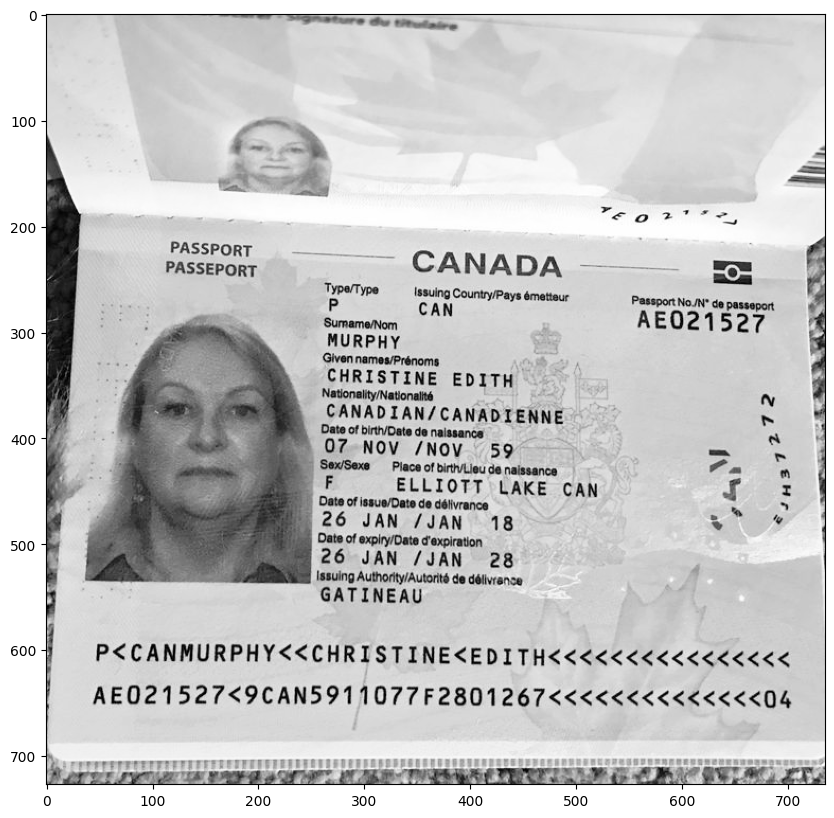

In [51]:
# Example usage
file_name = "/kaggle/input/ocr-dataset/OCR Dataset/Canada.jpg"
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
plot_gray(image)





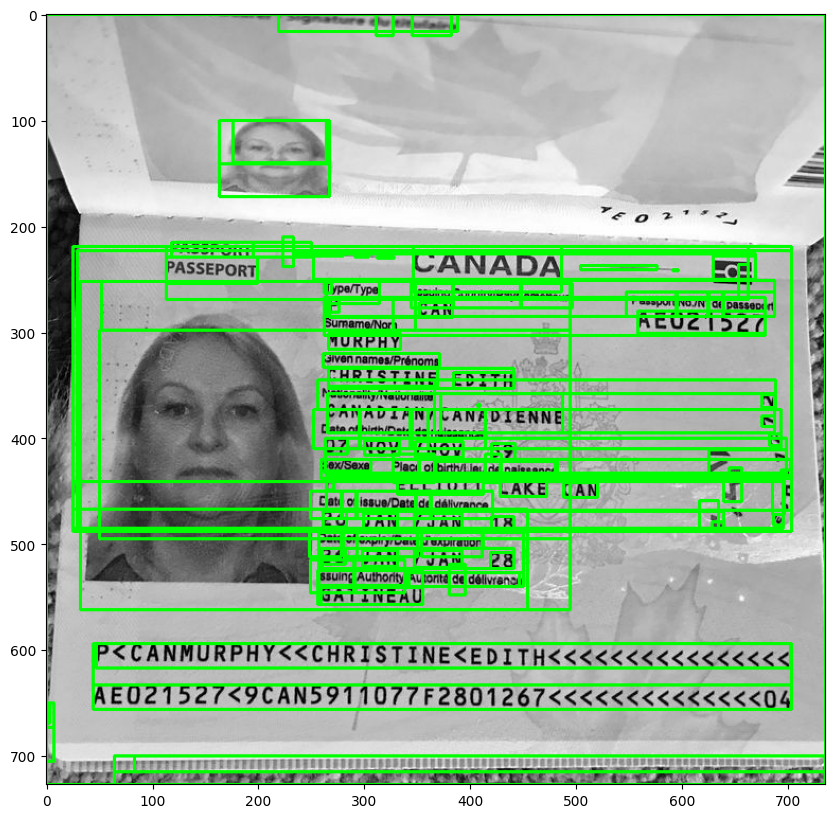

In [52]:
ocr_data = get_ocr_data(image)
boxes_image = draw_boxes(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB), ocr_data)
plot_rgb(boxes_image)

In [53]:


extracted_text = extract_text(image)
print(extracted_text)

(Oe et etna

a>
BSA,

PASSPORT © —

 
    
  

eee ee er ccna, ae zu
PASSEPORT " CANADA sa
'ype/Type Issuing Country/Pays émettour Passport NoN" de passeport
P CAN
Merete AEO21527
MURPHY
Ghrennames/Prineme
CHRISTINE EDITH
‘Nationality/Navonalsé : os
CANADIAN/ CANADIENNE 6
Dao bivDate de naasance 8
07 NOV /Nov 59 ie
Sew'Sexe Place of birhVLieu de naissance - =
F ELLIOTT LAKE CAN f =:
Po Date of issue/Date de délivrance: is %
26 JAN /JAN 18 .

Date of expiny/Date cexpiration
26 JAN /JAN 28
vAutonté de délivrence

Issuing Authorty
GATINEAU

P<CANMURPHY<<CHRISTINE<EDITH<<<<<<cc<c<ccccc<
AEO21527<9CAN5911077F2801267<<<<<<<<<c<<<<04

  
 

|
:



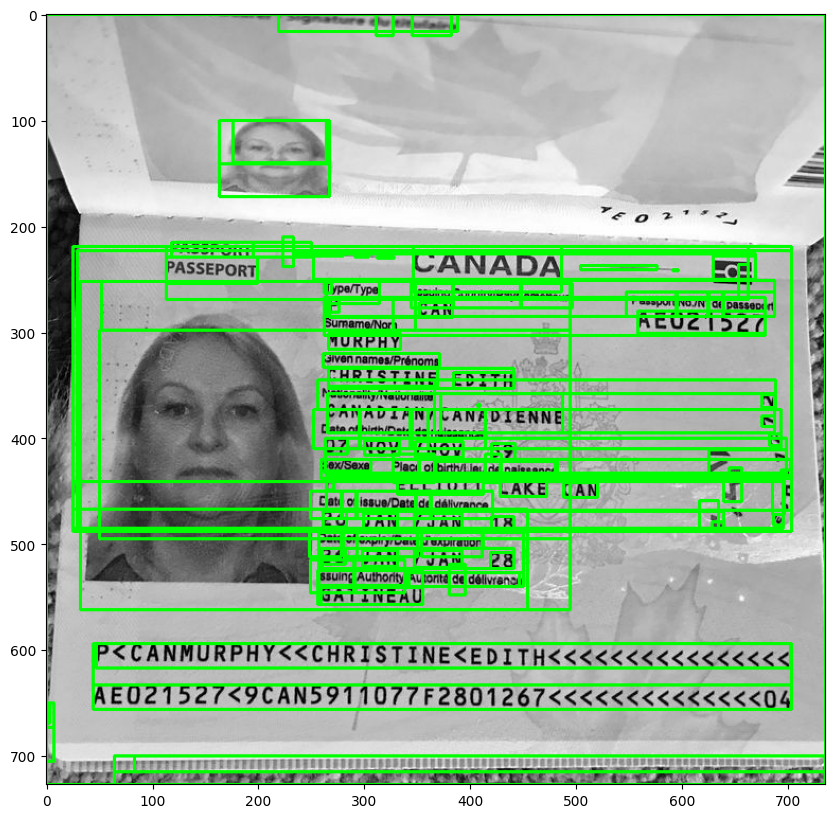

Coordinates of bounding boxes:
Box 1: (0, 0, 735, 727)
Box 2: (219, 0, 169, 16)
Box 3: (219, 0, 169, 16)
Box 4: (219, 0, 169, 16)
Box 5: (219, 0, 169, 16)
Box 6: (311, 0, 16, 20)
Box 7: (345, 0, 37, 20)
Box 8: (163, 100, 104, 72)
Box 9: (163, 100, 104, 72)
Box 10: (176, 100, 88, 40)
Box 11: (176, 100, 88, 40)
Box 12: (163, 141, 104, 31)
Box 13: (163, 141, 104, 31)
Box 14: (118, 215, 132, 14)
Box 15: (118, 215, 132, 14)
Box 16: (118, 215, 132, 14)
Box 17: (118, 215, 77, 14)
Box 18: (223, 210, 10, 28)
Box 19: (233, 225, 17, 2)
Box 20: (32, 252, 462, 310)
Box 21: (32, 252, 462, 310)
Box 22: (52, 252, 296, 46)
Box 23: (52, 252, 296, 46)
Box 24: (50, 298, 444, 197)
Box 25: (50, 298, 444, 197)
Box 26: (32, 467, 422, 95)
Box 27: (32, 467, 422, 95)
Box 28: (25, 219, 678, 269)
Box 29: (29, 223, 674, 265)
Box 30: (252, 226, 417, 24)
Box 31: (252, 226, 28, 2)
Box 32: (291, 228, 13, 1)
Box 33: (312, 229, 16, 1)
Box 34: (504, 237, 72, 4)
Box 35: (591, 241, 5, 1)
Box 36: (629, 228, 40, 22)
Box 37: (

In [61]:
ocr_data = get_ocr_data(image)
boxes_image, box_coordinates = draw_boxes(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB), ocr_data)
plot_rgb(boxes_image)

print("Coordinates of bounding boxes:")
for i, box in enumerate(box_coordinates):
    print(f"Box {i + 1}: {box}")

In [54]:
# Initialize PassportDataExtractor with the path to your country codes JSON file
country_codes_file = "/kaggle/input/country-codes/all.json"
extractor = PassportDataExtractor(country_codes_file)
data = extractor.get_data(img_name)
extractor.print_data(data)

Name	:	CHRISTINE EDITH MURPHY
Date of birth	:	07/11/1959
Date of issue	:	Not Found
Date of expiry	:	26/01/2028
Authority	:	Not Found
Nationality	:	Canada
Passport type	:	P
Passport number	:	AE021527
